# Create multi-label chips for multi-output regression sampled from the whole GB

Create chips and store proportions of signature types within as an input of multi-output regression problem

In [1]:
import geopandas
import tobler
import pyogrio
import pygeos
import numpy
import pandas
import dask_geopandas
import rasterio
from scipy.sparse import coo_matrix

import dask
import dask.bag
from dask.distributed import Client, LocalCluster

In [2]:
specs = {
    "chip_size": 64,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
}

In [3]:
%%time
df = geopandas.read_parquet(f"/home/jovyan/work/chips_gb/chip_bounds_{specs['chip_size']}/").reset_index(drop=True)

CPU times: user 383 ms, sys: 143 ms, total: 525 ms
Wall time: 444 ms


In [4]:
signatures = pyogrio.read_dataframe(        
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
)

In [5]:
bds = df.total_bounds
signatures = signatures.cx[bds[0]:bds[2], bds[1]:bds[3]]

In [6]:
%%time

ids_src, ids_tgt = df.sindex.query_bulk(signatures.geometry, predicate="intersects")

CPU times: user 14.2 s, sys: 57.1 ms, total: 14.3 s
Wall time: 14.3 s


In [7]:
od_matrix = pandas.DataFrame(dict(ids_src=ids_src, ids_tgt=ids_tgt))

In [8]:
%%time 
sjoined = df.set_geometry(df.centroid).sjoin(signatures[["signature_type", "geometry"]], how="left", predicate="within")

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


CPU times: user 1.97 s, sys: 55.8 ms, total: 2.02 s
Wall time: 2.02 s


In [9]:
od_matrix["signature_type"] = sjoined.signature_type.iloc[ids_tgt].values

In [10]:
cap = 10000
keep = []
counts = {k:0 for k in od_matrix.signature_type.unique()}
for i, t in od_matrix.signature_type.sample(len(od_matrix)).iteritems():
    counts[t] += 1
    if counts[t] < cap:
        keep.append(i)

In [11]:
limited = od_matrix.iloc[keep]

In [12]:
%%time
chips = df.geometry.values[limited.ids_tgt.values].data
sig = signatures.geometry.values[limited.ids_src.values].data

# this could be parallelised
r = [
    pygeos.clip_by_rect(
        g, *chip
    ) for g, chip in zip(sig, pygeos.bounds(chips))
]

areas = pygeos.area(r)

table = coo_matrix(
    (
        areas,
        (limited.ids_src.values, limited.ids_tgt.values),
    ),
    shape=(signatures.shape[0], df.shape[0]),
    dtype=numpy.float32,
)

table = table.tocsr()

CPU times: user 48.4 s, sys: 0 ns, total: 48.4 s
Wall time: 48.4 s


In [13]:
%%time
signatures["signature_type"] = pandas.Categorical(signatures["signature_type"])

CPU times: user 7.34 ms, sys: 0 ns, total: 7.34 ms
Wall time: 5.63 ms


In [14]:
%%time
categorical = {}
for value in signatures["signature_type"].unique():
    mask = signatures["signature_type"] == value
    categorical[value] = numpy.asarray(
        table[mask].sum(axis=0)
    )[0]
    print(value)

0_0
1_0
3_0
4_0
5_0
6_0
7_0
8_0
2_0
2_1
2_2
9_0
9_1
9_2
9_3
9_4
9_5
9_6
9_7
9_8
CPU times: user 34.3 ms, sys: 7.46 ms, total: 41.8 ms
Wall time: 38.3 ms


In [15]:
%%time
categorical = pandas.DataFrame(categorical)

CPU times: user 2.21 ms, sys: 7.96 ms, total: 10.2 ms
Wall time: 8.22 ms


In [16]:
%time areas = df.area.values
%time categorical = categorical.div(areas, axis="rows")

CPU times: user 15.4 ms, sys: 88 µs, total: 15.5 ms
Wall time: 14.2 ms
CPU times: user 4.81 ms, sys: 11.9 ms, total: 16.7 ms
Wall time: 16.5 ms


In [17]:
geom = df[df.geometry.name].reset_index(drop=True)
ests = geopandas.GeoDataFrame(categorical, geometry=geom, crs=signatures.crs)

In [18]:
ests = ests.iloc[limited.ids_tgt.values]

In [19]:
split = (.4, .1, .4,)
total = len(ests)

ests = ests.sample(frac=1, random_state=42)

ests['split'] = None
ests.iloc[:int(total * split[0])]['split'] = 'nn_train'
ests.iloc[int(total * (split[0])):int(total * (split[0] + split[1]))]['split'] = 'nn_val'
ests.iloc[int(total * (split[0] + split[1])):int(total * (split[0] + split[1] + split[2]))]['split'] = 'ml_train'
ests.iloc[int(total * (split[0] + split[1] + split[2])):]['split'] = 'ml_val'

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

<AxesSubplot:>

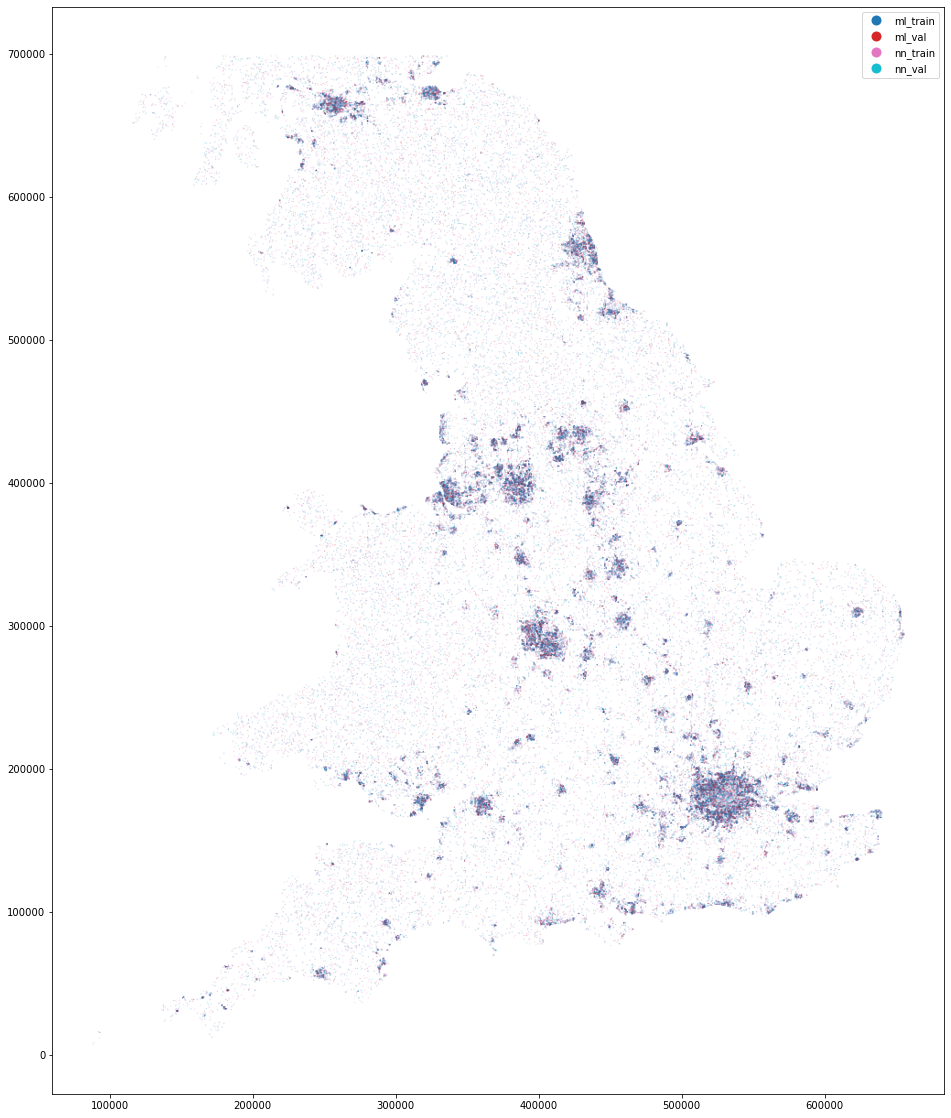

In [20]:
ests.set_geometry(ests.centroid).plot('split', figsize=(20, 20), markersize=.01, legend=True)

In [21]:
ests.to_parquet(f"../../chips_gb/v2_{specs['chip_size']}_multi_labels.parquet")

/tmp/ipykernel_2316/558250973.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ests.to_parquet(f"../../chips_gb/v2_{specs['chip_size']}_multi_labels.parquet")


In [22]:
centroid = ests.centroid
ests['X'] = centroid.x.astype(int)
ests['Y'] = centroid.y.astype(int)

In [23]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-do1_m47o', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-btmxrjs4', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-zw20do49', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-zud1mbo6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-a9jzfx7s', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/create_chips/dask-worker-space/worker-gqq28vre', purging
distributed.diskutils - INFO - Found stale lock file and directo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45991,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.54 GiB
Comm: tcp://172.17.0.2:33213,Total threads: 1
Dashboard: http://172.17.0.2:46207/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:36745,


In [24]:
import numpy as np

def bag_of_chips(chip_bbs, specs, npartitions):
    '''
    Load imagery for `chip_bbs` using a Dask bag
    ...
    
    Arguments
    ---------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    npartitions : int
                  No. of partitions to split `chip_bbs` before sending to
                  Dask for distributed computation
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data   
    '''
    # Split chip_bbs
    thr = np.linspace(0, chip_bbs.shape[0], npartitions+1, dtype=int)
    chunks = [
        (chip_bbs.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
    ]
    # Set up the bag
    bag = dask.bag.from_sequence(
        chunks, npartitions=npartitions
    ).map(chip_loader)
    # Compute
    chips = np.concatenate(bag.compute())
    return chips


def chip_loader(pars):
    '''
    Load imagery for `chip_bbs`
    ...
    
    Arguments (wrapped in `pars`)
    -----------------------------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data
    '''
    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    chips = np.zeros((chip_bbs.shape[0], b, s, s))
    with rasterio.open(specs['mosaic_p']) as src:
        for i, tup in enumerate(chip_bbs.itertuples()):
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for ban, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[ban][img[ban] > l_max] = l_max
                img[ban][img[ban] < l_min] = l_min
                a_std = (img[ban] - l_min) / (l_max - l_min)
                img[ban] = a_std * 255
            chips[i, :, :, :] = img
    chips = np.moveaxis(chips, 1, -1)
    return chips.astype(rasterio.uint8)

In [25]:
chips = bag_of_chips(ests, specs, 16)

In [26]:
numpy.save(f"../../chips_gb/v2_{specs['chip_size']}_multi.npy", chips)